In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from transformers import get_scheduler
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [2]:
label_to_id = {"entailment": 0, "neutral": 1, "contradiction": 2}
id_to_label = {v: k for k, v in label_to_id.items()}

def renameColumns(df):
    return df.rename(columns={'Sentence1': 'premise', 'Sentence2': 'hypothesis', 'Explanation_1': 'explanation'})

def filterNan(df):
    return df.dropna()

def convert_to_tensors(df):
    return torch.tensor(df.values)

def encode_labels(df):
    return df.apply(lambda x: int(label_to_id[x]))

template = "Given that {}, it is hypothesized that {}. {}."

def tokenize(df, tokenizer):
    tokenized_batch = []
    for _, row in df.iterrows():
        premise = row['premise'].lower()
        if premise[-1] in ['.', '!', '?']:
            premise = premise[:-1]
        hypothesis = row['hypothesis'].lower()
        if hypothesis[-1] in ['.', '!', '?']:
            hypothesis = hypothesis[:-1]
        explanation = row['explanation'].lower()
        if explanation[-1] in ['.', '!', '?']:
            explanation = explanation[:-1]


        encoded_dict = tokenizer.encode_plus(
            text = template.format(premise, hypothesis, explanation),
            padding=True,
            return_tensors='pt',
        )
        tokenized_batch.append(encoded_dict)
    return tokenized_batch

def calc_f1_score(predicted_classes, actual_labels):
    return f1_score(predicted_classes, actual_labels, average='weighted'), f1_score(predicted_classes, actual_labels, average='micro'), f1_score(predicted_classes, actual_labels, average='macro')

In [3]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# change the model's classifier to a smaller one
dense = nn.Linear(768, 256)
out = nn.Linear(256, 3)
model.classifier.dense = dense
model.classifier.out_proj = out

# freeze all the parameters in the base model
for name, param in model.named_parameters():
    param.requires_grad = False

# only train the classification head
for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
premise_template = 'Given that {}, it is hypothesized that {}.'
explanation_template = 'This is {} because {}.'

class eSNLIDataset(Dataset):
    def __init__(self, df, tokenizer, train=True):
        self.df = df
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        example = self.df.iloc[idx,:]
        premise = example["premise"]
        hypothesis = example["hypothesis"]
        explanation = example["explanation"]

        if premise[-1] in ['.', '!', '?']:
            premise = premise[:-1]
        if hypothesis[-1] in ['.', '!', '?']:
            hypothesis = hypothesis[:-1]
        if explanation[-1] in ['.', '!', '?']:
            explanation = explanation[:-1]

        premise = premise_template.format(premise, hypothesis)
        explanation = explanation_template.format(tokenizer.mask_token, explanation)

        if self.train:
            label = example["gold_label"]
            return premise, explanation, label
        
        return premise, explanation

In [5]:
df_train1 = pd.read_csv('esnli_train_1.csv')
df_train2 = pd.read_csv('esnli_train_2.csv')
df_train = pd.concat((df_train1, df_train2), axis=0)

df_dev = pd.read_csv('esnli_dev.csv')
df_test = pd.read_csv('esnli_test.csv')

In [6]:
df_train_renamed = renameColumns(df_train)
df_train_cleaned = filterNan(df_train_renamed)
df_train_cleaned.loc[:, "gold_label"] = encode_labels(df_train_cleaned["gold_label"])
df_train_final = df_train_cleaned.loc[:, ["gold_label", "premise", "hypothesis", "explanation"]]

df_train_final = df_train_final.sample(frac=0.20, random_state=0).reset_index(drop=True)

df_dev_renamed = renameColumns(df_dev)
df_dev_cleaned = filterNan(df_dev_renamed)
df_dev_cleaned.loc[:, "gold_label"] = encode_labels(df_dev_cleaned["gold_label"])
df_dev_final = df_dev_cleaned.loc[:, ["gold_label", "premise", "hypothesis", "explanation"]]

df_test_renamed = renameColumns(df_test)

In [7]:
from sklearn.model_selection import train_test_split
num_epochs = 5
train_batch_size = 64

train_final_df, val_final_df = train_test_split(df_train_final, test_size=0.25, random_state=0)  # Adjusted for clarification
train_dataset = eSNLIDataset(train_final_df, tokenizer)
val_dataset = eSNLIDataset(val_final_df, tokenizer)

In [8]:
train_dataset = eSNLIDataset(df_train_final, tokenizer)
dev_dataset = eSNLIDataset(df_dev_final, tokenizer, train=False)
test_dataset = eSNLIDataset(df_test, tokenizer, train=False)
 
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=train_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=train_batch_size)

In [8]:
# for mac
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# for nvidia GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from ray import train, tune
import os
import tempfile
import ray
from torch.optim import AdamW, SGD, Adam
from ray.train import Checkpoint
from tqdm.auto import tqdm

def train_model(config):
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # change the model's classifier to a smaller one
    dense = nn.Linear(768, 256)
    out = nn.Linear(256, 3)
    model.classifier.dense = dense
    model.classifier.out_proj = out

    # freeze all the parameters in the base model
    for name, param in model.named_parameters():
        param.requires_grad = False

    # only train the classification head
    for param in model.classifier.parameters():
        param.requires_grad = True
    model.to(device)
    train_dataloader = DataLoader(train_dataset, batch_size=config["train_batch_size"])
    val_dataloader = DataLoader(val_dataset, batch_size=config["train_batch_size"])
    
    if config["optimizer"] == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    elif config["optimizer"] == "SGD":
        optimizer = SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "Adam":
        optimizer = Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    else:
        raise ValueError("Unsupported optimizer")
    criterion = CrossEntropyLoss()
    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_path = os.path.join(checkpoint_dir, "checkpoint")
            model_state, optimizer_state = torch.load(checkpoint_path)
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    for epoch in range(num_epoch):
        model.train()  # Training phase
        train_losses = []
        for batch in train_dataloader:
            optimizer.zero_grad()

            premise, hypothesis, labels = batch
            encoded_input = tokenizer(premise, hypothesis, return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model(**encoded_input)
            logits = outputs.logits
            loss = criterion(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for batch in val_dataloader:
            with torch.no_grad():
                premise, hypothesis, labels = batch
                encoded_input = tokenizer(premise, hypothesis, return_tensors="pt", padding=True, truncation=True).to(device)
                outputs = model(**encoded_input)
                logits = outputs.logits
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()

                loss = criterion(logits, labels.to(device))
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Calculate metrics
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_val_loss = val_loss / val_steps
        accuracy = correct / total

        metrics = {
            "loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "accuracy": accuracy
        }

        # Checkpointing
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), checkpoint_path)

            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            if ray.train.get_context().get_world_rank() == 0:
                train.report(metrics, checkpoint=checkpoint)
            else:
                train.report(metrics)

#     for epoch in range(num_epochs):
#         losses = []
#         for batch in train_dataloader:
#             optimizer.zero_grad()
#             premise, hypothesis, labels = batch

#             encoded_input = tokenizer(premise, hypothesis, return_tensors="pt",padding=True, truncation=True).to(device)

#             outputs = model(**encoded_input)
#             logits = outputs.logits.to(device)

#             loss = criterion(logits, labels.to(device))
#             loss.backward()
#             losses.append(loss.item())

#             optimizer.step()

#         metrics = {
#             "loss": losses[-1]
#         }
        
#         with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
#             checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
#             if ray.train.get_context().get_world_rank() == 0:
#                 train.report(metrics, checkpoint=checkpoint)
#             else:
#                 train.report(metrics, checkpoint=None)


config = {
    "lr": tune.grid_search([1e-6, 1e-5, 1e-4, 1e-3]),
    "weight_decay": tune.grid_search([0.01, 0.03, 0.05, 0.08]),
    "optimizer": tune.choice(["AdamW", "SGD", "Adam"]),
    "train_batch_size": tune.choice([16, 32, 64]),
}

# config = {
#     "lr": 1e-6,
#     "weight_decay": 0.01,
#     "optimizer": "AdamW",
#     "train_batch_size": 16,
# }

analysis = tune.run(
    train_model,
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=config,
    num_samples=1000,
    stop={"training_iteration": 10},
    metric="loss",
    mode="min",
)

print("Best hyperparameters found were: ", analysis.best_config)

2024-04-09 16:33:57,179	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-04-09 16:33:58,150	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-04-09 16:33:58,153	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) Warning: The actor ImplicitFunc is very large (36 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_model pid=3343777) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(train_model pid=3343777) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trial name,accuracy,loss,val_loss
train_model_f6f38_00000,0.469558,1.09877,1.09594


In [ ]:
print("here")

In [ ]:
optimizer = AdamW(model.parameters())
                  # lr=5e-6, weight_decay=0.01)
num_training_steps = num_epochs * len(train_dataloader) # <- number of batches
# lr_scheduler = get_scheduler(
#     name="linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps
# )
criterion = CrossEntropyLoss()

In [ ]:
from tqdm.auto import tqdm

num_training_steps = num_epochs * len(train_dataloader) # <- number of batches

progress_bar = tqdm(range(num_training_steps))

y_true = []
losses = []

model.to(device)
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    for batch in train_dataloader:
        premise, hypothesis, labels = batch

        encoded_input = tokenizer(premise, hypothesis, return_tensors="pt",padding=True, truncation=True).to(device)
        
        outputs = model(**encoded_input)
        logits = outputs.logits.to(device)

        loss = criterion(logits, labels.to(device))
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        # lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

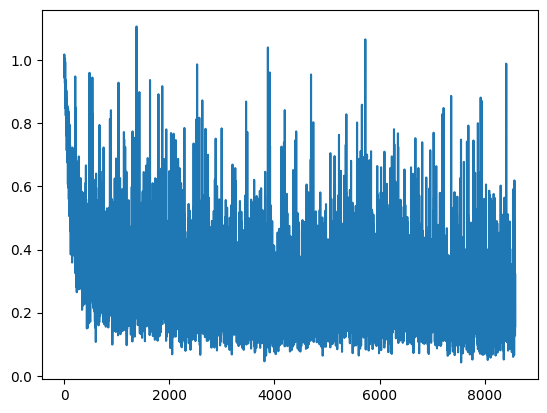

In [34]:
plt.plot(losses)
plt.show()

In [35]:
# predict after training
model.to(device)
model.eval()
predictions = []

actual_labels = df_dev_final['gold_label'].astype("int")

with torch.no_grad():
    for batch in dev_dataset:
        premise, hypothesis = batch
        
        encoded_input = tokenizer(premise, hypothesis, return_tensors="pt",padding=True, truncation=True).to(device)

        outputs = model(**encoded_input)
        logits = outputs.logits.cpu()

        predicted_classes = torch.argmax(logits, dim=1)
        predicted_classes = [pred.item() for pred in predicted_classes]
        predictions.extend(predicted_classes)

In [36]:
print(calc_f1_score(predictions, actual_labels))

(0.9171976059169357, 0.9176996545417598, 0.9180923836275922)


In [37]:
model.save_pretrained("esnli-model-2")